In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import random
import copy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

SEED = 42
random.seed(SEED)

df = pd.read_csv('synthetic_letters.csv')
df

,age,sentiment,sector,education,letter
0,39,extremely negative,academia,none,"To Whom It May Concern,\n\nI regret to write t..."
1,36,extremely negative,academia,trainee,"To Whom It May Concern,\n\nI regret to inform ..."
2,64,positive,finance,college,"To Whom It May Concern,\n\nI am pleased to rec..."
3,46,neutral,health,trainee,"To whom it may concern,\n\nI am writing to rec..."
4,53,negative,finance,trainee,"To Whom It May Concern,\n\nI regret to inform ..."
...,...,...,...,...,...
195,53,negative,finance,trainee,"To whom it may concern,\n\nI regret to inform ..."
196,36,extremely negative,finance,college,"To Whom It May Concern,\n\nI regret to inform ..."
197,23,negative,finance,college,"Dear [Recipient's Name],\n\nI regret to inform..."
198,22,positive,academia,trainee,"To whom it may concern,\n\nI am pleased to rec..."


In [2]:
def label(sentiment):
    if sentiment in ['extremely negative', 'negative']:
        return 'negative'
    elif sentiment in ['extremely positive', 'positive']:
        return 'positive'
    else: 
        return 'neutral'        
        
labels = [label(sentiment) for sentiment in df.sentiment]

train, rest, y_train, y_rest = train_test_split(df, labels, test_size=0.5, random_state=SEED)
valid, test, y_valid, y_test = train_test_split(rest, y_rest, test_size=0.5, random_state=SEED)

encoder = SentenceTransformer("all-MiniLM-L6-v2")
X_train = encoder.encode(list(train.letter))
X_valid = encoder.encode(list(valid.letter))
X_test = encoder.encode(list(test.letter))

In [3]:
def inject_label_errors(original_list, fraction):
    lst = copy.deepcopy(original_list)
    count = int(len(lst) * fraction)
    indices_to_shuffle = random.sample(range(len(lst)), count)
    elements_to_shuffle = [lst[i] for i in indices_to_shuffle]
    random.shuffle(elements_to_shuffle)
    for idx, element in zip(indices_to_shuffle, elements_to_shuffle):
        lst[idx] = element    
    return lst    

def evaluate_logistic_regression_model(X_train, y_train, X_test, y_test):
    model = SGDClassifier(loss='log_loss', random_state=SEED)
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    return { 'train_acc': train_acc, 'test_acc': test_acc, }
    

In [4]:
evaluate_logistic_regression_model(X_train, y_train, X_test, y_test)

{'train_acc': 0.99, 'test_acc': 0.86}

In [5]:
y_train_mislabeled = inject_label_errors(y_train, fraction=0.5)
evaluate_logistic_regression_model(X_train, y_train_mislabeled, X_test, y_test)

{'train_acc': 0.99, 'test_acc': 0.64}

In [6]:
from numba import njit, prange
import numpy as np

@njit(fastmath=True, parallel=True)
def compute_shapley_values(X_train, y_train, X_test, y_test, K=1):
    N = len(X_train)
    M = len(X_test)
    result = np.zeros(N, dtype=np.float32)

    for j in prange(M):
        score = np.zeros(N, dtype=np.float32)
        dist = np.zeros(N, dtype=np.float32)
        div_range = np.arange(1.0, N)
        div_min = np.minimum(div_range, K)
        for i in range(N):
            dist[i] = np.sqrt(np.sum(np.square(X_train[i] - X_test[j])))
        indices = np.argsort(dist)
        y_sorted = y_train[indices]
        eq_check = (y_sorted == y_test[j]) * 1.0
        diff = - 1 / K * (eq_check[1:] - eq_check[:-1])
        diff /= div_range
        diff *= div_min
        score[indices[:-1]] = diff
        score[indices[-1]] = eq_check[-1] / N
        score[indices] += np.sum(score[indices]) - np.cumsum(score[indices])
        result += score / M

    return result

In [7]:
label_indices = {
    'negative': -1,
    'positive': 1,
    'neutral': 0,
}

y_train_mislabeled_enc = np.array([label_indices[y] for y in y_train_mislabeled])
y_test_enc = np.array([label_indices[y] for y in y_test])

dsvs = compute_shapley_values(X_train, y_train_mislabeled_enc, X_test, y_test_enc)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: ylabel='Count'>

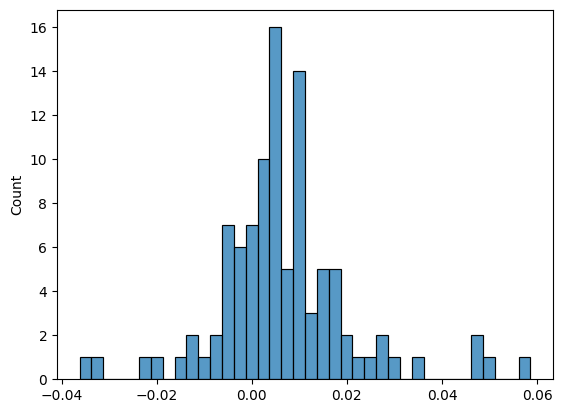

In [8]:
sns.histplot(data=dsvs, binwidth=0.0025)

In [27]:
num_negative_dsvs = np.sum(dsvs < 0)
y_train_mislabeled_some_fixes = copy.deepcopy(y_train_mislabeled)

indices = np.argsort(dsvs)[:num_negative_dsvs]

train_accs = []
test_accs = []

for index in indices:
    y_train_mislabeled_some_fixes[index] = y_train[index]
    impact = evaluate_logistic_regression_model(X_train, y_train_mislabeled_some_fixes, X_test, y_test)
    train_accs.append(impact['train_acc'])
    test_accs.append(impact['test_acc'])

    if y_train_mislabeled[index] != y_train[index]:
    
        print(f'''
Data Shapley value: {dsvs[index]}
Given label: {y_train_mislabeled[index]}
True label: {y_train[index]}

{train.iloc[index].letter}

{'-'*80}
''')
    
    #print(f'{dsvs[index]},{y_train_mislabeled[index]},{y_train[index]}')
    #impact = evaluate_logistic_regression_model(X_train, y_train_mislabeled_some_fixes, X_test, y_test)
    #train_accs.append(impact['train_acc'])
    #test_accs.append(impact['test_acc'])


Data Shapley value: -0.036256611347198486
Given label: negative
True label: neutral

To whom it may concern,

I am writing to recommend [person], who has worked in the health sector for several years. Throughout their career, [person] has demonstrated proficiency in managing patient records, conducting health assessments, and supporting healthcare teams in daily operations. Their ability to communicate effectively with both patients and colleagues has contributed positively to the working environment. [Person]'s experience in implementing health initiatives and adhering to compliance regulations has proven valuable in their role. I believe [person] would be a reliable addition to any team in the health field. 

Sincerely,  
[Your Name]  
[Your Position]  
[Your Organization]  

--------------------------------------------------------------------------------


Data Shapley value: -0.03135325387120247
Given label: positive
True label: neutral

To whom it may concern,

I am writing to re

<Axes: >

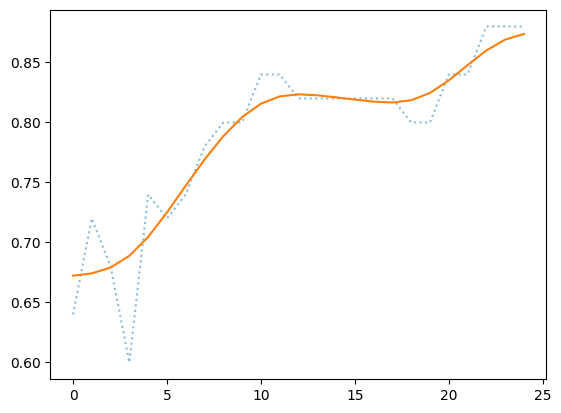

In [42]:
from scipy.ndimage import gaussian_filter1d

sns.lineplot(test_accs, linestyle='dotted', alpha=0.5)
sns.lineplot(gaussian_filter1d(test_accs, sigma=2))